### María Sofía Álvarez - Brenda Barahona - Álvaro Plata

<h1 align='center'>Proyecto 1: Analítica de textos - Preprocesamiento</h1>

## Instalación de librerías
<b><font color='blue'>Importante:</font></b> Correr antes de ejecutar el notebook. Con una única vez que se corra, basta.

In [1]:
#!pip install spacy==2.3.0
#!python -m spacy download en_core_web_sm
#!pip install wordcloud
#!pip install contractions
#!pip install nltk
#!pip install inflect
#!pip install unicode
#!pip install stopwords
#!pip install scispacy
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_ner_bionlp13cg_md-0.5.0.tar.gz
#!pip install sent2vec

## Importación de librerías
Importamos las librerías necesarias para el desarrollo de este proyecto

In [41]:
# ESAI
import re
import nltk
import spacy
import inflect
import sent2vec # Para descargar esta libreria, es necesario descargarla desde GitHub https://github.com/epfml/sent2vec
import stopwords
import numpy as np
import unicodedata
import pandas as pd
import contractions
import seaborn as sns
nltk.download('wordnet')
nltk.download('omw-1.4')
import en_ner_bionlp13cg_md
import pandas_profiling as pp
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.utils import resample 
from nltk import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
%matplotlib inline


Procedemos, entonces, a ver los datos suministrados.

In [4]:
diagnoses =pd.read_csv('ApoyoDiagnosticoEstudiante/medical_text_clasificacion.csv')

In [5]:
X, Y = diagnoses['medical_abstracts'], diagnoses['problems_described']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,stratify=Y,test_size=0.2, random_state=28)

Con esto, procedemos a hacer todo el entrenamiento sobre el conjunto de $X_{\mathrm{train}},Y_{\mathrm{train}}$ y guardamos el test en la "caja fuerte" hasta que sea el momento de la validación.

Queremos ver la distribución de las clases de nuestro conjunto de datos. Para ello, consideremos el siguiente histograma y la distribución de los textos de acuerdo con sus clases:

## 2. Preprocesamiento

### Balanceo de clases
Como vimos en el preprocesamiento, volvamos a ver qué tan desbalanceadas están las clases de nuestro problema:

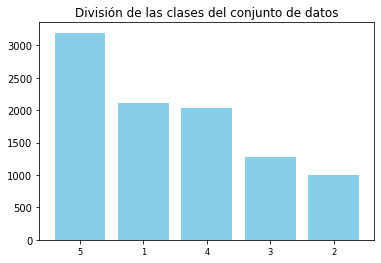

Veamos la cantidad de datos en cada clase: 


,problems_described
5,3194
1,2103
4,2029
3,1280
2,994


In [6]:
val_counts_y = Y_train.value_counts()
plt.bar(range(len(val_counts_y)), val_counts_y.values, align='center',color='skyblue')
plt.xticks(range(len(val_counts_y)), val_counts_y.index.values, size='small')
plt.title('División de las clases del conjunto de datos')
plt.show()

print('Veamos la cantidad de datos en cada clase: ')
Y_train.value_counts().to_frame()

Podemos ver claramente que las clases están notablemente desbalanceadas. Vemos que la clase con más datos es la 5, lo cual es consecuente con el hecho de que esta es la clase más amplia, al tratar condiciones patológicas generales. Debemos clasificar todas las clases igual de bien, pues nos interesa conocer con precisión qué enfermedad posee cada paciente particular. Por esta razón, debemos utilizar técnicas de balanceo de clases. Podemos abordar este problema desde el preprocesamiento, probaremos realizando un submuestreo de los datos, y usando técnicas de oversampling como SMOTE, o en la implementación del algoritmo, diciéndole que estamos trabajando con clases desbalanceadas (aunque esto depende de los algoritmos a utilizar, los cuales se definirán más adelante. En particular, una variación de Naïve-Bayes permite esta implementación). Quisiéramos ver todos los comportamientos, entonces intentaremos explorar estas alternativas. Esto se realiza más adelante, en las secciones de preprocesamiento y modelado (respectivamente) de este documento.

Conviene en este momento explicar las técnicas de preprocesamiento que seguiremos. En cuanto a limpieza, tokenización y stemming:
1. Usamos funciones de corrección de ruido, tokenización, stemming y lematización sobre nuestro conjunto de datos.
2. Usamos el modelo preentrenado de SpaCy entrenado sobre un conjunto de textos médicos, que extrae las palabras más relevantes de un texto médico.

Lo primero que hacemos es realizar unas fases de preprocesamiento común que servirán tanto para el subsampling como el oversampling:

In [7]:
# Primero, volvemos a juntar los datos de train:
data_train = pd.concat( [X_train, Y_train], axis=1)
data_train.sample(5)

,medical_abstracts,problems_described
7078,Dislocation after total hip arthroplasty. Caus...,5
3757,Muscle biopsy for diagnosis of malignant hyper...,3
8451,Biliary cholesterol transport and precipitatio...,2
2835,"Perioperative methotrexate, vinblastine, doxor...",4
8246,Diagnosis of noninfective cardiac mass lesions...,4


### Extracción de entidades médicas
De acuerdo con [4], para clasificación en contextos médicos es útil extraer entidades médicas para la clasificación:

In [8]:
nlp = en_ner_bionlp13cg_md.load()
def medical_entities(text):
    entities = []
    doc = nlp(text)
    for ent in doc.ents:
        entities.append(ent.text)
    return ' '.join(entities)

In [9]:
data_train['medical_entities'] = data_train['medical_abstracts'].apply(medical_entities)
data_train.sample(5)

,medical_abstracts,problems_described,medical_entities
4110,"Caloric expenditure, life status, and disease ...",4,HBP cardiovascular ATH kilocalories HBP
5472,Transaortic endarterectomy of renal visceral a...,4,Transaortic infrarenal infrarenal aortic graft...
5632,Clinical features of misdiagnosed appendicitis...,2,children children children patients Children p...
9125,Diagnostic fine-needle puncture of the gallbla...,2,fine-needle puncture gallbladder fine-needle g...
4360,The role of bacteria in pigment gallstone dise...,2,pigment gallstone disease patients GS pigment ...


Podemos ver que la mayoría de oraciones se han reducido a solamente algunas pocas palabras del léxico médico, de acuerdo conel corpus preentrenado BIONLP13. Con el fin de no sesgar mucho nuestro algoritmo, haremos los algoritmos sobre ambos conjuntos de datos: el preprocesado con BIONLP13 y el normal.

### Manejo de Ruido 
En esta sección se quitará o modificará todo lo que se considere como ruido:

+ Caracteres no ascii: Hace parte importante del preprocesamiento de las palabras. Con caracteres no-ascii, el preprocesamiento puede verse terriblemente perjudicado.
+ Se pasará de mayusculas a minusculas: Asimismo, es importante que todas las palabras tengan una capitalización homogénea (en este caso, queremos que estén en minúscula).
+ Se eliminará la puntuación: Por otro lado, consideramos que la puntuación no provee información adicional en este contexto. Adicionalmente, de no eliminarse, puede aumentar la dimensionalidad de los datos sin proveer más información. Por ejemplo, no tiene sentido pensar que "almuerzo!" y "almuerzo" sean palabras diferentes. Por ello removemos toda la puntuación usando expresiones regulares.
+ Se reemplazarán los números: Ahora, podemos suponer que los números no proveen información relevante para el problema en cuestión. Estos pueden también agregar dimensionalidad inutilmente al problema.
+ Se quitarán las fechas (si las hay) también: las fechas son irrelevantes para el contexto del problema.
+ Se quitarán las palabras vacias (artículos, pronombres, preposiciones): Estas se denominan stop-words, en inglés. Son palabras que se usan en muchos contextos (como 'the') y no aportan información significativa en la construcción del modelo. Asimismo, definimos nuestras propias stopwords de acuerdo con el perfilamiento realizado, pues son palabras que no aportan significativamente al contexto.

In [10]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
    

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        new_word = re.sub('\d+.*', '', word)
        if not word.isnumeric() and new_word != '':
            new_words.append(word)
    return new_words

def remove_dates(words):
    """Replace all dates in our data"""
    new_words = []
    for word in words:
        new_word = re.sub(r'\d+/\d+/\d+', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

Ahora, eliminaremos algunas palabras que no consideramos importantes o relevantes para el problema. Podemos ver cuales son las palabras más importantes de la wordcloud que hicimos en el notebook de perfilamiento:

In [11]:
%store -r wc
print(list(wc.words_.keys())[:20])

['patient', 'case', 'p less', 'treatment', 'group', 'associated', 'result', 'may', 'effect', 'compared', 'year', 'study', 'tumor', 'two', 'one', 'disease', 'found', 'normal', 'month', 'lesion']


De todas estas palabras, encontramos que solamente tumor y lesion pueden ser relevantes para nuestro análisis. Por lo tanto, las quitamos todas, excepto estas dos. Además, en un análisis preliminar encontramos otras palabras irrelevantes, las cuales también eliminamos.

In [12]:
#En una primera iteracion nos dimos cuenta que las palabras "paty", "patients" aparece frecuentemente en todas las enfermedades,
#estos serán eliminados por que no agregan información valiosa. 
our_stopwords = ["paty","patients","p","study","result", "human", "humans", "monkey", "monkeys", 
                 "diseases", "studied","first", "rat", "patient", "case", "p less", "treatment", 
                 "group", "associated", "result", "may", "effect", "compared", "use", "cases", "year", 
                 "years", "age", "study", "disease", "found", "normal", "month", "although", "per cent",
                 "one", "two", "three", "four", "n", "children", "women"]

def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords.words('english') and word not in our_stopwords:
            new_words.append(word)
    return new_words

In [13]:
def noise_elimination(words):
    words = to_lowercase(words)
    words = remove_non_ascii(words)
    words = remove_numbers(words)
    words = remove_dates(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

Con esto, ya tenemos casi listo nuestro proceso de eliminación del ruido. Primero, llamamos a la función <code>fix</code> de la librería ```contraction``` para aquellas contracciones que no están separadas en dos palabras. Esta elimina todas las ocurrencias de contracciones en inglés, reemplazándolas por su equivalente sin contracción. Una vez realizado este paso, "tokenizamos" las historias clínicas. Para poder evaluar cada palabra por separado y aplicar los pasos de preprocesamiento, hacemos la tokenización en palabras individuales usando el módulo ```word_tokenize```. Finalmente, aplicamos la función```noise_elimination``` definida previamente.

Más adelante, lo que realmente nos servirá será volver a tener los documentos sin tokenización para el proceso de vectorización (sea tf-idf, o BioSentVec, como se vera mas adelante). Entonces, volvemos a juntar todas las palabras para cada documento y retornamos eso. También retornamos las palabras tokenizadas con el fin de realizar la lematización estemización más adelante.

Note que estas funciones las aplicamos tanto sobre los medical abstracts iniciales, como las palabras clave que obtuvimos con la librería de SpaCy descrita previamente.

In [14]:
def preprocessing(X):
    new_X_train= X.apply(contractions.fix) #Aplica la corrección de las contracciones
    new_X_train = new_X_train.apply(word_tokenize)
    new_X_train = new_X_train.apply(noise_elimination) #Aplica la eliminación del ruido
    X_train = new_X_train.apply(lambda x: ' '.join(map(str, x)))
    return new_X_train, X_train

In [15]:
tokenized_abstracts, non_tokenized_abstracts = preprocessing(data_train["medical_abstracts"])
tokenized_entities, non_tokenized_entities = preprocessing(data_train["medical_entities"])

Después de esta eliminación de ruido y de palabras no informativas, veamos cuáles son las palabras de mayor uso en ambos conjuntos de datos:

In [16]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,min_font_size = 10).generate(" ".join(data.values))                       
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show()
    return wordcloud

Para los abstracts iniciales:

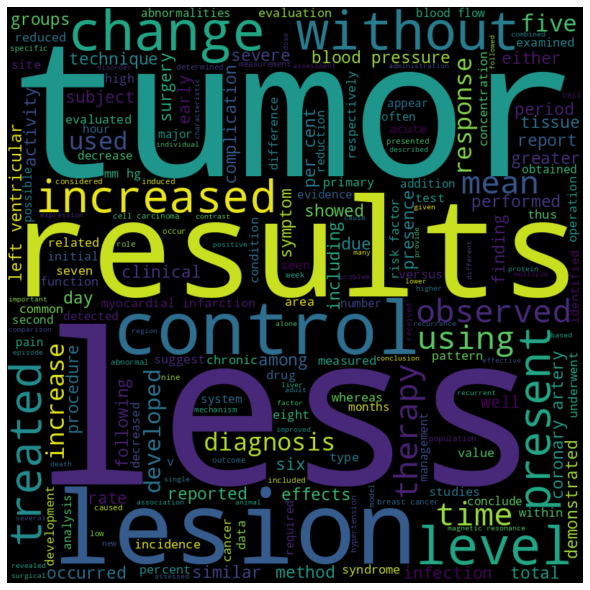

In [17]:
wordCloud_generator(non_tokenized_abstracts)

Para las aplabras obtenidas por medio de la librería:

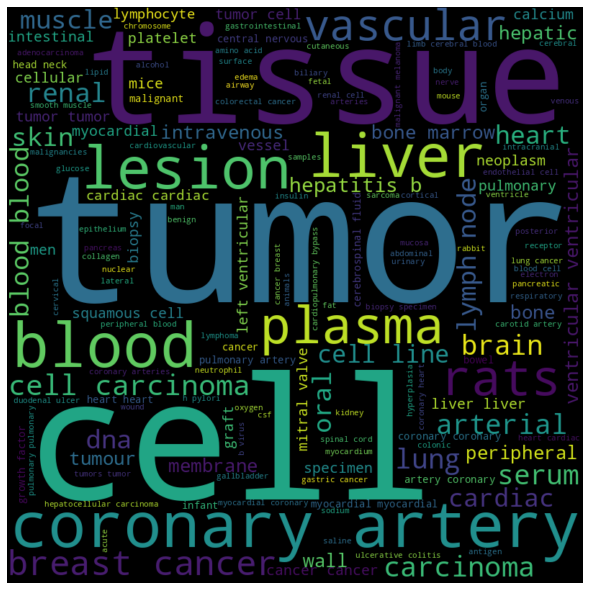

In [18]:
wordCloud_generator(non_tokenized_entities)

Podemos ver que las palabras que pusimos en nuestras stopwords sí son más relevantes ahora en el nuevo contexto. Es fácil ver que las extraidas por medio de la librería son mucho más relevantes que las de los textos originales.

### Normalización: Stemming y Lemmatization 
Aplicaremos tecnicas como "Stemming" y "Lemmatization" sobre la columna "medical_abstracts" y "medical_entities". 

En esta parte del preprocesamiento, hacemos una eliminación de prefijos y sufijos, así como una lematización de los verbos. En el caso del Stemming hay varios algoritmos que podemos utilizar: Porter, Snowball (Porter2) o Lancaster (Paice-Husk). De acuerdo a lo que encontramos,  <a href="https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg"> la agresividad en el corte de raíces de las palabras de estos algoritmos aumenta, siendo Porter el menos agresivo y Lancaster el más agresivo </a>. En este sentido, parece ser que Lancaster (a pesar de ser el más eficiente de todos), puede ser poco riguroso y así crear muchas ambigüedades. Asimismo, Porter2 es un poco más agresivo que Porter, sin perder mucho el origen de las palabras y con un tiempo de cómputo razonable. El mismo Porter, creador del algoritmo, argumenta que es una mejora de su algoritmo original. Con el fin de tener la mejor preparación de las palabras, en un tiempo de cómputo razonable, decidimos usar Porter2. En el caso de la lematización, sí usamos WordNetLemmatizer() al ser el más usado en el mundo del procesamiento de textos.

In [19]:
#Funciones de "Stemming" y "Lemmatization"
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

In [20]:
def join_stem_and_lemmatize(tokenized):
    return tokenized.apply(lambda x: ' '.join(map(str, x)))

In [21]:
tokenized_abstracts = tokenized_abstracts.apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
tokenized_entities = tokenized_entities.apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.

non_tokenized_abstracts = join_stem_and_lemmatize(tokenized_abstracts)
non_tokenized_entities = join_stem_and_lemmatize(tokenized_entities)

In [22]:
# Vemos una muestra de nuestro nuevo conjunto de abstracts
tokenized_abstracts.head(5)

5659     [placebo, control, trial, xamoterol, versus, d...
11557    [signific, blast, lowcellcount, cerebrospin, f...
1509     [obstruct, sleep, apnea, follow, topic, oropha...
6883     [experi, sarn, centrifug, pump, ventricular, a...
3844     [fine, surfac, structur, intraspin, neurenter,...
Name: medical_abstracts, dtype: object

In [23]:
# Vemos una muestra de nuestro nuevo conjunto de entities
tokenized_entities.head(5)

5659     [xamoterol, digoxin, heart, xamoterol, digoxin...
11557    [blast, lowcellcount, cerebrospin, fluid, spec...
1509     [oropharyng, airway, upper, airway, sem, oroph...
6883     [sarn, centrifug, ventricular, sarn, centrifug...
3844     [fine, surfac, intraspin, neurenter, cyst, ele...
Name: medical_entities, dtype: object

Esta es la primera fase del preprocesamiento de textos. Lo que viene, es la vectorización de las palabras. No obstante, esta cambia de acuerdo con el algoritmo a implementar. De acuerdo con [4], hay varios tipos de algoritmos para la vectorización, entre ellos:
<img src="images/text_encoding_types.png" width=25%/>
No obstante, no todos los algoritmos de vectorización sirven para todos los algoritmos. De nuevo, [4] establece que:
<img src="images/text_encoding_algorithms.png" width=75%/>
Debido a la naturaleza de los algoritmos a implementar, en este caso se usará TF-iDF y Count-Vectorizer para los algoritmos de Naïve-Bayes y OnevsRest. Asimismo, como implementaremos una red neuronal (LSTM), para este caso usaremos un tipo especial de word embedding, denominado BioWordVec, que es un tipo de word embedding especial para contextos médicos.

Note que todo esto se realiza en un notebook diferente.

## Resultados de preprocesamiento : Visualización de palabras mas frecuentes 

Después de haber hecho la limpieza de los datos y antes de empezar con c/u de los modelos, veremos cuales son las palabras (ya preprocesadas) más frecuentes según cada diagnóstico. 

In [24]:
nuevo_df = data_train[['problems_described']].copy()
nuevo_df['tokenized_abstracts'] = tokenized_abstracts
nuevo_df['non_tokenized_abstracts'] = non_tokenized_abstracts
nuevo_df['non_tokenized_entities'] = non_tokenized_entities
nuevo_df['tokenized_entities'] = tokenized_entities
nuevo_df.sample(5)

,problems_described,tokenized_abstracts,non_tokenized_abstracts,non_tokenized_entities
6477,5,"[fleck, retina, ring, chromosom, report, menta...",fleck retina ring chromosom report mental reta...,retina subretin drusenlik deposit eye retina c...
11037,4,"[high, nacl, diet, enhanc, arteri, barorecepto...",high nacl diet enhanc arteri baroreceptor refl...,arteri baroreceptor naclsensit rat arteri baro...
700,5,"[new, surgic, approach, complic, gastroesophag...",new surgic approach complic gastroesophag refl...,gastroesophag pariet cell peptic strictur esop...
7305,5,"[ethamsyl, reduc, haemorrhag, transurethr, pro...",ethamsyl reduc haemorrhag transurethr prostate...,ethamsyl transurethr prostatectomi transurethr...
9376,1,"[esophag, ultrasound, preoper, stage, carcinom...",esophag ultrasound preoper stage carcinoma eso...,esophag carcinoma esophagus esophag wall lymph...


In [25]:
def wordCloud_generator_2(data_1, data_2, title=None):
    wordcloud_1 = WordCloud(width = 800, height = 800,min_font_size = 10).generate(" ".join(data_1.values))
    wordcloud_2 = WordCloud(width = 800, height = 800,min_font_size = 10).generate(" ".join(data_2.values))                       
    fig, axs = plt.subplots(1,2,figsize = (8, 8), facecolor = None) 
    axs[0].imshow(wordcloud_1, interpolation='bilinear') 
    axs[1].imshow(wordcloud_2, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 5) 
    plt.suptitle(title,fontsize=15)
    plt.show()
    return wordcloud_1, wordcloud_2

Para neoplasias:

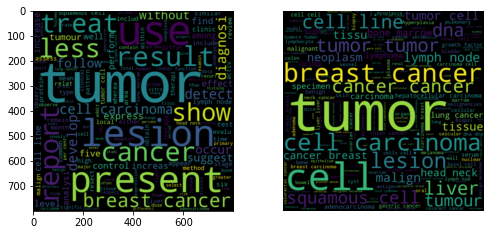

(<wordcloud.wordcloud.WordCloud at 0x10a863f70>,
 <wordcloud.wordcloud.WordCloud at 0x180e24a00>)

In [26]:
#1. Neoplasms
wordCloud_generator_2(nuevo_df[nuevo_df['problems_described'] == 1]['non_tokenized_abstracts'],
                     nuevo_df[nuevo_df['problems_described'] == 1]['non_tokenized_entities'])

A la izquierda, tenemos la nube de palabras para los abstracts y, a la derecha, la de las entidades. Vemos que una de las palabras más comunes es tumor, como es de esperarse.

Para enfermadades del sistema digestivo:

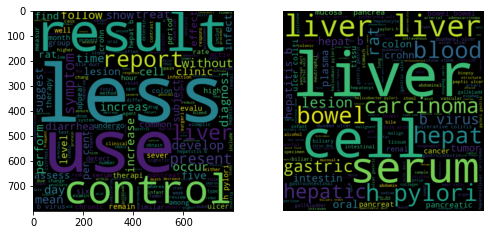

(<wordcloud.wordcloud.WordCloud at 0x180e24eb0>,
 <wordcloud.wordcloud.WordCloud at 0x180e24310>)

In [27]:
#2. Digestive system diseases
wordCloud_generator_2(nuevo_df[nuevo_df['problems_described'] == 2]['non_tokenized_abstracts'],
                     nuevo_df[nuevo_df['problems_described'] == 2]['non_tokenized_entities'])

No es tan claro a la izquierda alguna palabra particular que resalte, pero a la derecha tenemos hepatitis b, hígado, intestino, duodeno y úlcera, todas palabras relacionadas con este sistema.

Para enfermedades del sistema nervioso:

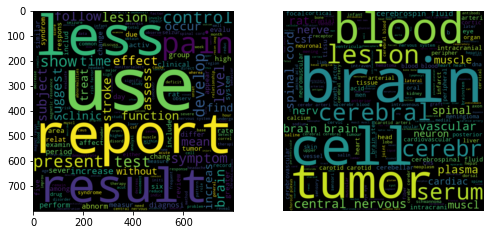

(<wordcloud.wordcloud.WordCloud at 0x18183fe80>,
 <wordcloud.wordcloud.WordCloud at 0x10a8c38e0>)

In [28]:
#3. Nervous system diseases
wordCloud_generator_2(nuevo_df[nuevo_df['problems_described'] == 3]['non_tokenized_abstracts'],
                     nuevo_df[nuevo_df['problems_described'] == 3]['non_tokenized_entities'])

De nuevo, son más claras las palabras en el segundo wordcloud. Casi todas tienen que ver con el cerebro y la columna vertebral.

Para enfermedades cardiovasculares:

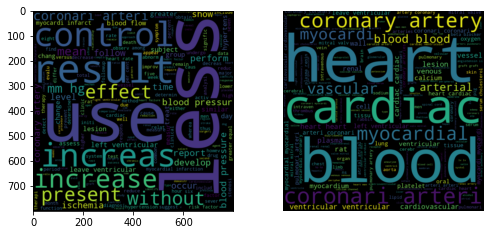

(<wordcloud.wordcloud.WordCloud at 0x17f64f8e0>,
 <wordcloud.wordcloud.WordCloud at 0x180e243d0>)

In [29]:
#4. Cardiovascular diseases
wordCloud_generator_2(nuevo_df[nuevo_df['problems_described'] == 4]['non_tokenized_abstracts'],
                     nuevo_df[nuevo_df['problems_described'] == 4]['non_tokenized_entities'])

En este caso, ambos son informativos. Vemos a la izquierda y a la derecha que las palabras que resaltan esán relacionadas con arterias coronarias, arterias pulmonares, sangre, miocardio, corazón, etc.

Finalmente, para enfermedades patológicas generales:

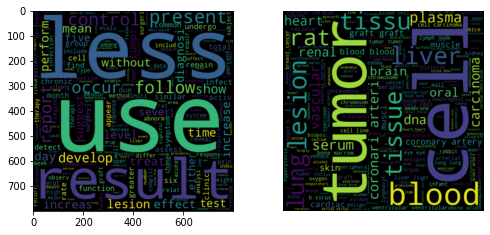

(<wordcloud.wordcloud.WordCloud at 0x18188ca90>,
 <wordcloud.wordcloud.WordCloud at 0x181868940>)

In [30]:
#5. General pathological conditions
wordCloud_generator_2(nuevo_df[nuevo_df['problems_described'] == 5]['non_tokenized_abstracts'],
                     nuevo_df[nuevo_df['problems_described'] == 5]['non_tokenized_entities'])

Esta es la que suponemos será más difícil para el algoritmo. En este caso, las enfermedades pueden estar relacionadas con cualquier cosa, por lo que debe tenerse cuidado con el modelo en esta ocasión.

Antes de proceder con almacenar el modelo, somos conscientes de que los datos de test deben atravesar este mismo preprocesamiento para ser evaluados. Por lo tanto, pasamos el conjunto a través de los mismos pasos que seguimos previamente para train:

In [31]:
data_test= pd.concat( [X_test, Y_test], axis=1)
# Abstraccion de entidades - recordemos que sobre esta se aplica un modelo diferente
data_test['medical_entities'] = data_test['medical_abstracts'].apply(medical_entities)
# Aplicacion de las funciones de preprocesamiento
tokenized_abstracts_test, non_tokenized_abstracts_test = preprocessing(data_test["medical_abstracts"])
tokenized_entities_test, non_tokenized_entities_test = preprocessing(data_test["medical_entities"])
# Aplicacion de funciones de lematizacion y stemming
tokenized_abstracts_test = tokenized_abstracts_test.apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
tokenized_entities_test = tokenized_entities_test.apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.

non_tokenized_abstracts_test = join_stem_and_lemmatize(tokenized_abstracts_test)
non_tokenized_entities_test = join_stem_and_lemmatize(tokenized_entities_test)

In [35]:
nuevo_df_test = data_test[['problems_described']].copy()
nuevo_df_test['tokenized_abstracts'] = tokenized_abstracts_test
nuevo_df_test['non_tokenized_abstracts'] = non_tokenized_abstracts_test
nuevo_df_test['non_tokenized_entities'] = non_tokenized_entities_test
nuevo_df_test['tokenized_entities'] = tokenized_entities_test
nuevo_df_test.sample(5)

,problems_described,tokenized_abstracts,non_tokenized_abstracts,non_tokenized_entities,tokenized_entities
1682,2,"[gallbladd, surgeri, follow, cholecystlithotri...",gallbladd surgeri follow cholecystlithotripsi ...,gallbladd lithotripsi acut cholecyst gallbladd...,"[gallbladd, lithotripsi, acut, cholecyst, gall..."
1159,5,"[hypertroph, pylor, stenosi, volumetr, measur,...",hypertroph pylor stenosi volumetr measur nasog...,pylor nasogastr aspir gastric infant pylor hps...,"[pylor, nasogastr, aspir, gastric, infant, pyl..."
853,1,"[pilot, suramin, metastat, renal, cell, carcin...",pilot suramin metastat renal cell carcinoma su...,suramin renal cell carcinoma sodium cellular s...,"[suramin, renal, cell, carcinoma, sodium, cell..."
8353,1,"[complic, limb, salvag, extrem, sarcoma, manag...",complic limb salvag extrem sarcoma manag retro...,limb extrem sarcoma limb tumor wound bone graf...,"[limb, extrem, sarcoma, limb, tumor, wound, bo..."
3948,5,"[heat, induc, radial, segment, leukocyt, nucle...",heat induc radial segment leukocyt nuclei poly...,heat leukocyt nuclei polymyalgia leukocyt nucl...,"[heat, leukocyt, nuclei, polymyalgia, leukocyt..."


Finalmente, almacenamos el dataframe. Recordemos que, como el preprocesamiento es un poco costoso computacionalmente, es preferible hacer los pasos siguientes en otro notebook y guardar lo que se tiene hasta aquí. Esto está en cada uno de los notebooks para cada modelo ```Proyecto-1-Alvarez-Barahona-Plata-modelo-X.ipynb```.

In [36]:
nuevo_df.to_csv("train_Data.csv")
nuevo_df_test.to_csv("test_Data.csv")

También los almacenamos:

In [37]:
%store nuevo_df
%store nuevo_df_test

Stored 'nuevo_df' (DataFrame)
Stored 'nuevo_df_test' (DataFrame)


#BioSentVec
model_path = 'BioSentVec_PubMed_MIMICIII-bigram_d700.bin'
model = sent2vec.Sent2vecModel()
try:
    model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

<h2 id='bibliografia'>Bibliografía</h2>

---

<a id='geron'>[1]</a> Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow : concepts, tools, and techniques to build intelligent systems. Sebastopol, CA: O'Reilly Media. ISBN: 978-1491962299

<a id='nlp_profiler'>[2]</a> https://towardsdatascience.com/nlp-profiler-profiling-datasets-with-one-or-more-text-columns-9b791193db89

[3] https://www.kaggle.com/code/neomatrix369/nlp-profiler-simple-dataset/notebook

[4] Clinical Text Classification: https://www.kaggle.com/ritheshsreenivasan/clinical-text-classification